## Importing libraries

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from joblib import dump

## Dataset Exploration


#### Loading dataset

In [2]:
dataset_path = r'plantvillage-dataset/color'
tomato_directories = [os.path.join(dataset_path, folder) for folder in os.listdir(dataset_path) if 'Tomato' in folder]
categories = ['HEALTHY', 'MOSAIC VIRUS', 'TARGET SPOT', 'EARLY BLIGHT', 'LATE BLIGHT', 'BACTERIAL SPOT', 'TWO SPOTTED SPIDER MITE', 'YELLOW LEAF CURL VIRUS', 'LEAF MOLD', 'SEPTORIA LEAF SPOT']
mapping_dictionary = {
    'Tomato___healthy': categories[0],
    'Tomato___Tomato_mosaic_virus': categories[1],
    'Tomato___Target_Spot': categories[2],
    'Tomato___Early_blight': categories[3],
    'Tomato___Late_blight': categories[4],
    'Tomato___Bacterial_spot': categories[5],
    'Tomato___Spider_mites Two-spotted_spider_mite': categories[6],
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': categories[7],
    'Tomato___Leaf_Mold': categories[8],
    'Tomato___Septoria_leaf_spot': categories[9]
}

#### Example image of each class

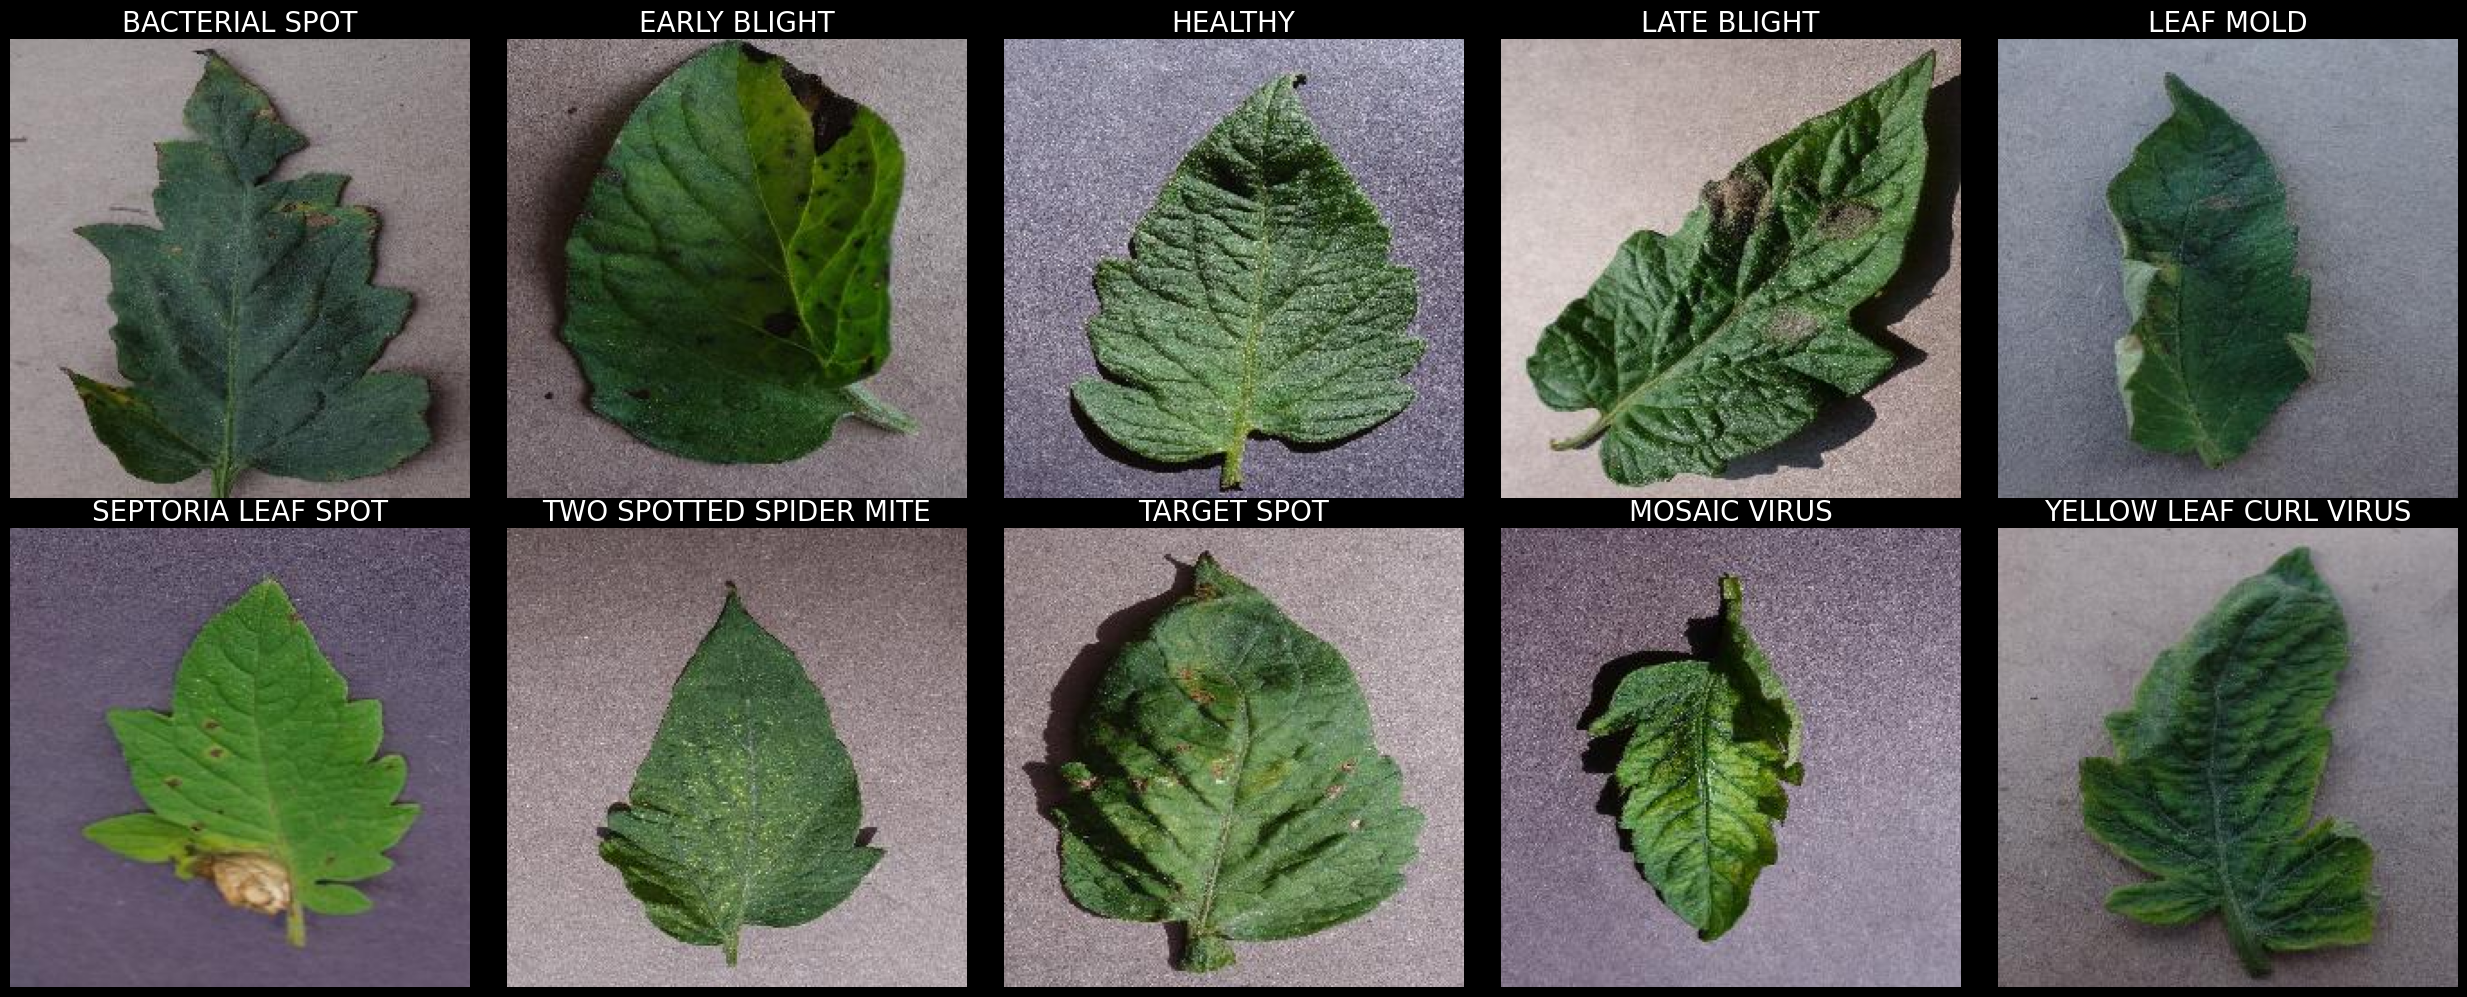

In [3]:
fig, axis = plt.subplots(nrows = 2, ncols = 5, figsize = (25, 10))
axis = axis.flatten()
for tomato_dir, ax in zip(tomato_directories, axis):
    image_path = os.path.join(tomato_dir, random.choice(os.listdir(tomato_dir)))
    image = plt.imread(image_path)
    ax.axis('off')
    ax.set_title(mapping_dictionary[os.path.basename(tomato_dir)], fontsize = 20)
    ax.imshow(image)
plt.tight_layout()
plt.show()

In [4]:
# tomato_diseases=[os.path.basename(folder)[9:] for folder in tomato_directories]
# tomato_diseases_number=[len(os.listdir(folder)) for folder in tomato_directories]
# for tomato_disease, number in zip(tomato_diseases, tomato_diseases_number):
#     print(tomato_disease, ": ", number)
# plt.barh(tomato_diseases, tomato_diseases_number)
# plt.tight_layout()
# plt.show()

#### Image preprocessing

In [5]:
# Generating 1000 images of mosaic virus
# datagen=ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# n=1000
# mosaic_virus_path=r'plantvillage-dataset\color\Tomato___Tomato_mosaic_virus'
# mosaic_virus_images=np.array([plt.imread(os.path.join(mosaic_virus_path, folder)) for folder in os.listdir(mosaic_virus_path)])
# i=0
# for batches in datagen.flow(mosaic_virus_images, batch_size=32, shuffle=True, seed=100, save_to_dir=mosaic_virus_path, save_prefix='augmented', save_format='jpg'):
#     for images in batches:
#         i+=1
#         print(str(i)+"images")
#         if(i>1000):break
#     if(i>1000):break

BACTERIAL SPOT :  2127
EARLY BLIGHT :  1000
HEALTHY :  1591
LATE BLIGHT :  1909
LEAF MOLD :  952
SEPTORIA LEAF SPOT :  1771
TWO SPOTTED SPIDER MITE :  1676
TARGET SPOT :  1404
MOSAIC VIRUS :  1375
YELLOW LEAF CURL VIRUS :  5357


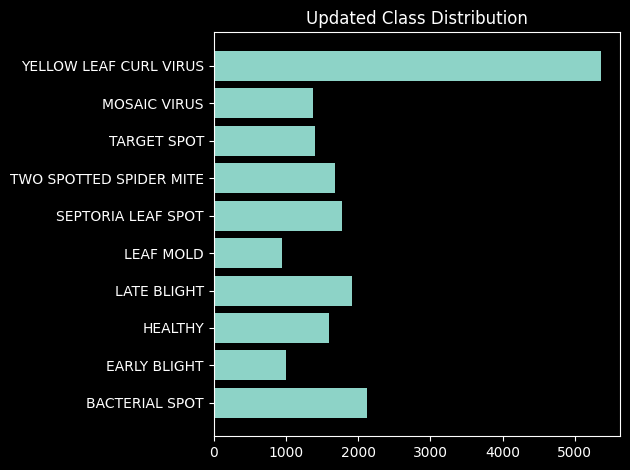

In [6]:
tomato_diseases=[mapping_dictionary[os.path.basename(folder)] for folder in tomato_directories]
tomato_diseases_number=[len(os.listdir(folder)) for folder in tomato_directories]
for tomato_disease, number in zip(tomato_diseases, tomato_diseases_number):
    print(tomato_disease, ": ", number)
plt.barh(tomato_diseases, tomato_diseases_number)
plt.title('Updated Class Distribution')
plt.tight_layout()
plt.show()

In [7]:
images=[]
labels=[]
for i,tomato_dir in enumerate(tomato_directories):
    print("Started: ", os.path.basename(tomato_dir))
    for file in os.listdir(tomato_dir)[:500]:
        image_path=os.path.join(tomato_dir, file)
        image=plt.imread(image_path)
        images.append(image)
        labels.append(mapping_dictionary[os.path.basename(tomato_dir)])
    print('Finished. {} classes to go.'.format(len(tomato_directories)-1-i))

images=np.array(images)
labels=np.array(labels)

Started:  Tomato___Bacterial_spot
Finished. 9 classes to go.
Started:  Tomato___Early_blight
Finished. 8 classes to go.
Started:  Tomato___healthy
Finished. 7 classes to go.
Started:  Tomato___Late_blight
Finished. 6 classes to go.
Started:  Tomato___Leaf_Mold
Finished. 5 classes to go.
Started:  Tomato___Septoria_leaf_spot
Finished. 4 classes to go.
Started:  Tomato___Spider_mites Two-spotted_spider_mite
Finished. 3 classes to go.
Started:  Tomato___Target_Spot
Finished. 2 classes to go.
Started:  Tomato___Tomato_mosaic_virus
Finished. 1 classes to go.
Started:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
Finished. 0 classes to go.


In [8]:
images = images/255.0
labels

array(['BACTERIAL SPOT', 'BACTERIAL SPOT', 'BACTERIAL SPOT', ...,
       'YELLOW LEAF CURL VIRUS', 'YELLOW LEAF CURL VIRUS',
       'YELLOW LEAF CURL VIRUS'], dtype='<U23')

In [9]:
print(images.shape)
images[0]

(5000, 256, 256, 3)


array([[[0.58431373, 0.56078431, 0.56078431],
        [0.59215686, 0.56862745, 0.56862745],
        [0.6       , 0.57647059, 0.57647059],
        ...,
        [0.62352941, 0.6       , 0.60784314],
        [0.61568627, 0.59215686, 0.6       ],
        [0.61176471, 0.58823529, 0.59607843]],

       [[0.59607843, 0.57254902, 0.57254902],
        [0.59607843, 0.57254902, 0.57254902],
        [0.60392157, 0.58039216, 0.58039216],
        ...,
        [0.61960784, 0.59607843, 0.60392157],
        [0.61960784, 0.59607843, 0.60392157],
        [0.61960784, 0.59607843, 0.60392157]],

       [[0.60392157, 0.58039216, 0.58039216],
        [0.60392157, 0.58039216, 0.58039216],
        [0.60392157, 0.58039216, 0.58039216],
        ...,
        [0.61568627, 0.59215686, 0.6       ],
        [0.61960784, 0.59607843, 0.60392157],
        [0.61960784, 0.59607843, 0.60392157]],

       ...,

       [[0.47058824, 0.43137255, 0.43529412],
        [0.45882353, 0.41960784, 0.42352941],
        [0.45490196, 0

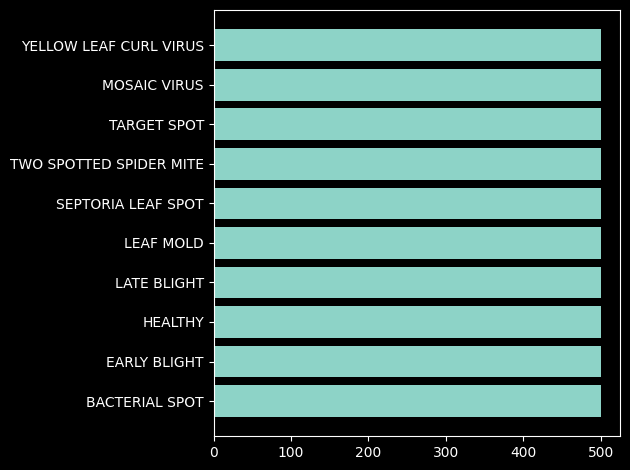

In [10]:
# Class distribution
c = Counter(labels)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.tight_layout()
plt.show()

#### Train Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

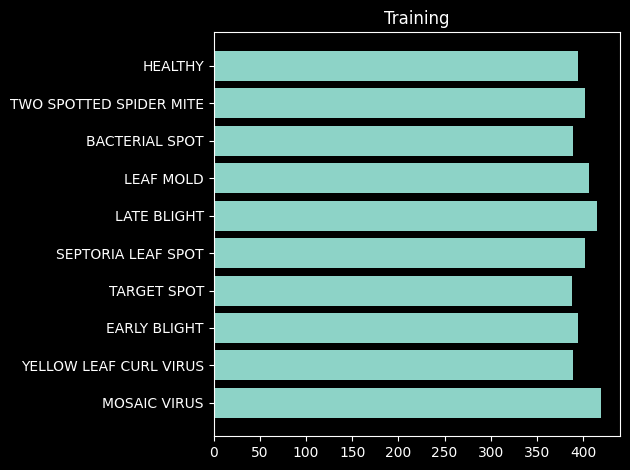

In [12]:
# Training class distribution
c = Counter(y_train)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.title('Training')
plt.tight_layout()
plt.show()

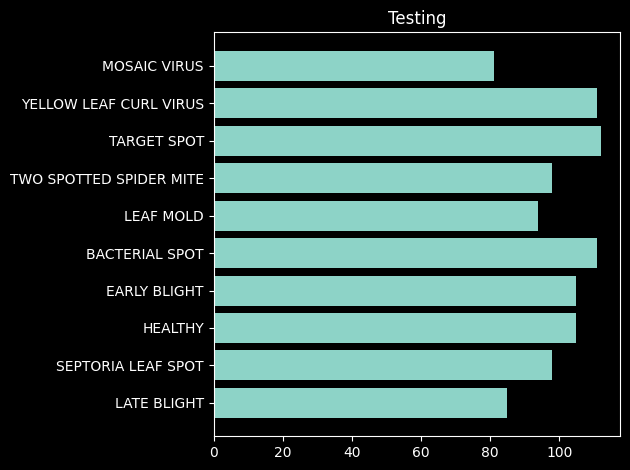

In [13]:
# Training class distribution
c = Counter(y_test)
l = list(c.keys())
n = list(c.values())
plt.barh(l, n)
plt.title('Testing')
plt.tight_layout()
plt.show()

#### One Hot Encoding of Training Labels

In [14]:
reshaped_labels = y_train.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output = False)
encoded_labels = encoder.fit_transform(reshaped_labels)

In [15]:
encoder.categories_

[array(['BACTERIAL SPOT', 'EARLY BLIGHT', 'HEALTHY', 'LATE BLIGHT',
        'LEAF MOLD', 'MOSAIC VIRUS', 'SEPTORIA LEAF SPOT', 'TARGET SPOT',
        'TWO SPOTTED SPIDER MITE', 'YELLOW LEAF CURL VIRUS'], dtype='<U23')]

In [16]:
dump(encoder, r'model_weights/encoder.joblib')

['model_weights/encoder.joblib']

## Model Architecture:

In [17]:
def cnn_model(input_shape, number_of_classes):
    input_image = Input(shape=(input_shape), name='input_layer')
    
    #Block 1: Input Layer
    x = Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_1_1')(input_image)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_1')(x)
    
    #Block 2:
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_2_1')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_2')(x)
    
    #Block 3:
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu', name = 'conv_3_1')(x)
    x = MaxPooling2D(pool_size = (2,2), strides = (2,2))(x)
    x = Dropout(0.25, name = 'dropout_layer_3')(x)
    
    #Flatten:
    x = Flatten()(x)
    
    #Dense Layer:
    x = Dense(128, activation = 'relu', name = 'dense_1')(x)
    x = Dense(128, activation = 'relu', name = 'dense_2')(x)
    x = Dense(64, activation = 'relu', name = 'dense_3')(x)
    x = Dense(number_of_classes, activation = 'softmax', name = 'output_dense_layer')(x)
    
    model = Model(inputs = input_image, outputs = x)
    
    return model

In [18]:
tomato_classifier = cnn_model((256, 256, 3), 10)
tomato_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
tomato_classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_1 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_2 (Dropout)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_3 (Dropout)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,896,010 (64.45 MB)

 Trainable params: 16,896,010 (64.45 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Dataset

In [19]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
history = tomato_classifier.fit(x_train, encoded_labels, epochs = 20, batch_size = 32, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 684ms/step - accuracy: 0.1222 - loss: 2.9168 - val_accuracy: 0.3512 - val_loss: 1.7353
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 663ms/step - accuracy: 0.4639 - loss: 1.5354 - val_accuracy: 0.6562 - val_loss: 1.0346
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 655ms/step - accuracy: 0.6863 - loss: 0.9367 - val_accuracy: 0.6800 - val_loss: 0.9032
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 623ms/step - accuracy: 0.7732 - loss: 0.6676 - val_accuracy: 0.7163 - val_loss: 0.7989
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 654ms/step - accuracy: 0.7972 - loss: 0.6008 - val_accuracy: 0.7575 - val_loss: 0.7315
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 653ms/step - accuracy: 0.8594 - loss: 0.4149 - val_accuracy: 0.8263 - val_loss: 0.5393
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 642ms/step - accuracy: 0.8903 - loss: 0.3191 - val_accuracy: 0.8188 - val_loss: 0.5506
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 634ms/step - accuracy: 0.9190 - loss: 0

#### Prediction and Accuracy

In [20]:
pred = tomato_classifier.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step


In [21]:
predictions = []
for p in pred:
    predictions.append(encoder.categories_[0][np.argmax(p)])

In [22]:
predictions

['EARLY BLIGHT',
 'SEPTORIA LEAF SPOT',
 'BACTERIAL SPOT',
 'HEALTHY',
 'EARLY BLIGHT',
 'EARLY BLIGHT',
 'EARLY BLIGHT',
 'LATE BLIGHT',
 'LEAF MOLD',
 'SEPTORIA LEAF SPOT',
 'LEAF MOLD',
 'BACTERIAL SPOT',
 'EARLY BLIGHT',
 'EARLY BLIGHT',
 'TWO SPOTTED SPIDER MITE',
 'TARGET SPOT',
 'HEALTHY',
 'YELLOW LEAF CURL VIRUS',
 'LATE BLIGHT',
 'HEALTHY',
 'EARLY BLIGHT',
 'TWO SPOTTED SPIDER MITE',
 'HEALTHY',
 'EARLY BLIGHT',
 'YELLOW LEAF CURL VIRUS',
 'EARLY BLIGHT',
 'MOSAIC VIRUS',
 'BACTERIAL SPOT',
 'YELLOW LEAF CURL VIRUS',
 'BACTERIAL SPOT',
 'EARLY BLIGHT',
 'BACTERIAL SPOT',
 'YELLOW LEAF CURL VIRUS',
 'BACTERIAL SPOT',
 'EARLY BLIGHT',
 'SEPTORIA LEAF SPOT',
 'TARGET SPOT',
 'MOSAIC VIRUS',
 'YELLOW LEAF CURL VIRUS',
 'LEAF MOLD',
 'LEAF MOLD',
 'MOSAIC VIRUS',
 'EARLY BLIGHT',
 'BACTERIAL SPOT',
 'TARGET SPOT',
 'TARGET SPOT',
 'TWO SPOTTED SPIDER MITE',
 'YELLOW LEAF CURL VIRUS',
 'TWO SPOTTED SPIDER MITE',
 'TARGET SPOT',
 'YELLOW LEAF CURL VIRUS',
 'YELLOW LEAF CURL VIRUS',

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
accuracy

0.81

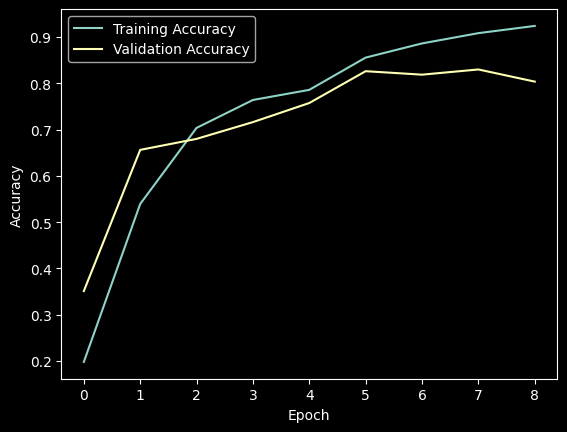

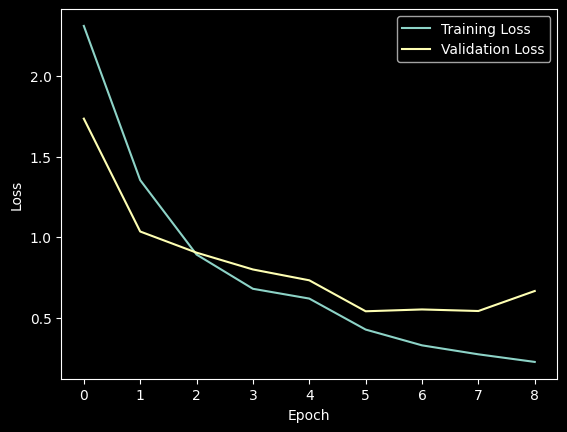

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

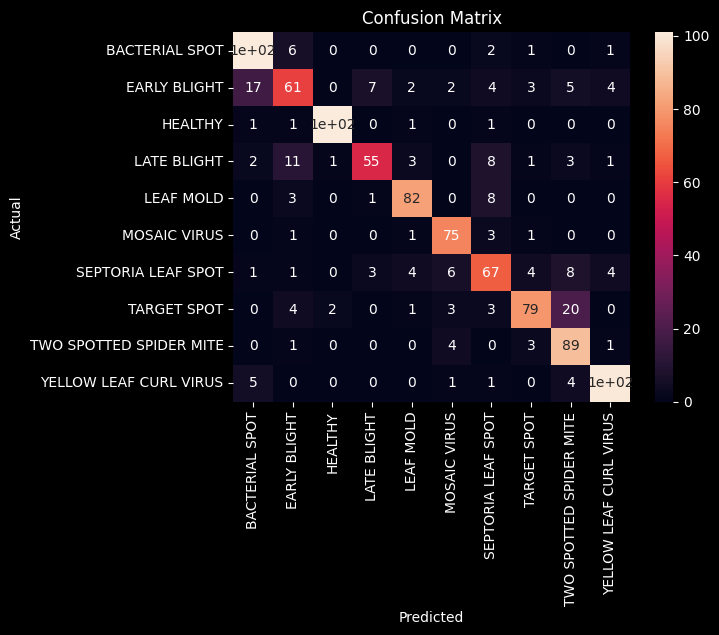

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, predictions)
sn.heatmap(cm, annot=True, xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
from tensorflow.keras.models import save_model
tomato_classifier.save(r'model_weights\tomato\accuracy_806.keras')